In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plot
from tensorflow.examples.tutorials.mnist import input_data
from optim.optimisticmirroradam import AdamirrorOptimizer

In [16]:
batch_size = 32
X_dim = 784
z_dim = 10
h_dim = 128
lambda_grad = 10
lr = 0.0001
n_disc = 5

In [17]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [18]:
def plot_images(samples):
    fig = plot.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plot.subplot(gs[i])
        plot.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plot.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [19]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

# D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
# D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# D_W2 = tf.Variable(xavier_init([h_dim, 1]))
# D_b2 = tf.Variable(tf.zeros(shape=[1]))

# theta_D = [D_W1, D_W2, D_b1, D_b2]


z = tf.placeholder(tf.float32, shape=[None, z_dim])

# G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
# G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# theta_G = [G_W1, G_W2, G_b1, G_b2]

In [20]:
def get_sample_z(size):
    return np.random.uniform(-1., 1., size=size)

In [21]:
def generator(z):
    with tf.variable_scope('generator') as scope:
        G_h1 = tf.layers.dense(z, units=h_dim, kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        G_out = tf.nn.sigmoid(tf.layers.dense(G_h1, units=X_dim, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer()))
        return G_out

In [22]:
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        D_h1 = tf.layers.dense(x, units=h_dim, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        D_out = tf.layers.dense(D_h1, units=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        return D_out

In [23]:
generator_sample = generator(z)
discriminator_real = discriminator(X)
discriminator_fake = discriminator(generator_sample, True)

In [24]:
epsilon = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
interpolated = epsilon * X + (1 - epsilon) * generator_sample
grads = tf.gradients(discriminator(interpolated, True), [interpolated])[0]
grad_norm = tf.sqrt(tf.reduce_sum((grads) ** 2, axis=1))
gp = lambda_grad * tf.reduce_mean((grad_norm - 1) ** 2)

In [25]:
d_loss = tf.reduce_mean(discriminator_fake) - tf.reduce_mean(discriminator_real) + gp
g_loss = -tf.reduce_mean(discriminator_fake)

In [26]:
g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
d_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

d_step = AdamirrorOptimizer(learning_rate=lr).minimize(d_loss, var_list=d_vars)
g_step = AdamirrorOptimizer(learning_rate=lr).minimize(g_loss, var_list=g_vars)

In [27]:
print(g_vars)

[<tf.Variable 'generator/dense/kernel:0' shape=(10, 128) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>]


In [28]:
print(d_vars)

[<tf.Variable 'discriminator/dense/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'discriminator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/bias:0' shape=(1,) dtype=float32_ref>]


In [29]:
sess = tf.InteractiveSession()

In [30]:
sess.run(tf.global_variables_initializer())

Iteration: 0 - Discriminator Loss: 4.253, Generator Loss: 6.127


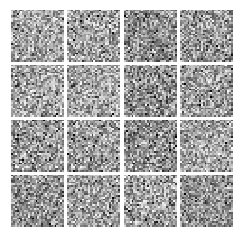

Iteration: 100 - Discriminator Loss: 8.581, Generator Loss: 8.493
Iteration: 200 - Discriminator Loss: 5.823, Generator Loss: 3.259
Iteration: 300 - Discriminator Loss: 4.682, Generator Loss: 1.31
Iteration: 400 - Discriminator Loss: 3.563, Generator Loss: 0.4523
Iteration: 500 - Discriminator Loss: 3.445, Generator Loss: -0.1471
Iteration: 600 - Discriminator Loss: 3.553, Generator Loss: -0.4193
Iteration: 700 - Discriminator Loss: 3.381, Generator Loss: -0.4529
Iteration: 800 - Discriminator Loss: 3.535, Generator Loss: -0.4712
Iteration: 900 - Discriminator Loss: 3.088, Generator Loss: -0.4608
Iteration: 1000 - Discriminator Loss: 3.375, Generator Loss: -0.4732


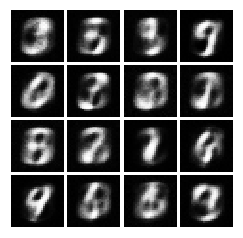

Iteration: 1100 - Discriminator Loss: 2.974, Generator Loss: -0.4498
Iteration: 1200 - Discriminator Loss: 2.935, Generator Loss: -0.5918
Iteration: 1300 - Discriminator Loss: 3.198, Generator Loss: -0.5607
Iteration: 1400 - Discriminator Loss: 2.928, Generator Loss: -0.6792
Iteration: 1500 - Discriminator Loss: 3.001, Generator Loss: -0.6073
Iteration: 1600 - Discriminator Loss: 3.045, Generator Loss: -0.5857
Iteration: 1700 - Discriminator Loss: 3.027, Generator Loss: -0.8311
Iteration: 1800 - Discriminator Loss: 2.936, Generator Loss: -0.7305
Iteration: 1900 - Discriminator Loss: 2.922, Generator Loss: -0.8119
Iteration: 2000 - Discriminator Loss: 3.01, Generator Loss: -0.7837


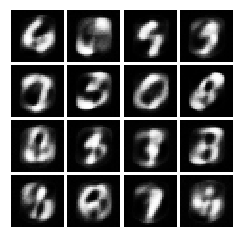

Iteration: 2100 - Discriminator Loss: 2.862, Generator Loss: -0.7384
Iteration: 2200 - Discriminator Loss: 3.019, Generator Loss: -0.6576


In [ ]:
for i in range(100000):
    for _ in range(n_disc):
        x_batch, _ = mnist.train.next_batch(batch_size)

        _, d_loss_val = sess.run(
            [d_step, d_loss],
            feed_dict={X: x_batch, z: get_sample_z(size=(batch_size, z_dim))}
        )

    _, g_loss_val = sess.run(
        [g_step, g_loss],
        feed_dict={z: get_sample_z(size=(batch_size, z_dim))}
    )

    if i % 100 == 0:
        print('Iteration: {} - Discriminator Loss: {:.4}, Generator Loss: {:.4}'
              .format(i, -d_loss_val, g_loss_val))

        if i % 1000 == 0:
            samples = sess.run(generator_sample, feed_dict={z: get_sample_z(size=(16, z_dim))})

            fig = plot_images(samples)
            plot.show()
            i += 1
            plot.close(fig)